Imports the nessacary libraries and packages for this notebook

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import emcee
from scipy.integrate import quad


First we read in the data and converts the distance modulus data into distance in parsecs. The equation for distance modulus is $\mu (\text{distance modulus}) = m - M = 5 \log_{10} \left( {d_{\text{pc}}} \right) - 5$. $d_{\text{pc}}$ represents the distance in parsecs so we can just rewrite the equation for $\mu$ in terms of $d_{\text{pc}}$. This gives us the equation:
     
${d_{\text{pc}}} = 10^{((\mu+5)/5)}$

We define the function compute_distance_pc to allow us to convert the distance modulus data into distance in parsecs. Additionally in this chunk we read in the data from the csv.

In [13]:
#The function that converts distance modulus to distance in parsecs
def compute_distance_pc(distance_modulus):
    return 10 ** ((distance_modulus + 5) / 5)
data = pd.read_csv('Hubble.csv')
data['Shoes_Distance_pc'] = compute_distance_pc(data['MU_SH0ES'])

#renames the columns into a more convient form
data['zHD_redshift'] = data['zHD']
data['zHD_redshift_error'] = data['zHDERR']


For the first problem we are only dealing with data within 100 megapasecs, so we are creating a filtered data set to work with. 

In [14]:
#This grabs only the data that is close to the earth
Close_data = data.loc[data['Shoes_Distance_pc'] < (100 * 1e6)]

Now we create our model that are MCMC walkers are going to use. It will be the hubble relation which is $cz=Hd$, where c is the speed of light, z is the redshift, H is the hubble constant, and d is the distance in parsecs. 
     
Our prior makes sure the walkers never get a negative value for the hubble constant, because that could never be the case(unless somehow the universe was contracting).

The likelyhood function takes in the hubble constant from the walkers and the distance data and calculates a predicted veloctity using the hubble relation. Then it compares what the model predicts to the actual data and calculates the likelyhood of that hubble constant given the data.

The pdf function uses both the prior and likelyhood function to calculate the posterior probability of the hubble constant given the data.

In [15]:
def velocity(hubble, distance_pc):
    return hubble * (distance_pc * 1e-6) # pc to Mpc

def ln_prior(hubble):
    if 0 < hubble:
        return 0
    return -np.inf

def ln_likelihood(hubble, distance_data, velocity_data_km_s, velocity_data_error):
    velocity_model_predicted = velocity(hubble, distance_data)
    return -0.5 * np.sum(((velocity_data_km_s - velocity_model_predicted) / velocity_data_error) ** 2)

def ln_pdf(params, distance_data, velocity_data_km_s, velocity_data_error):
    hubble = params
    p = ln_prior(hubble)
    if p == -np.inf:
        return -np.inf
    return p + ln_likelihood(hubble, distance_data, velocity_data_km_s, velocity_data_error)

This is the code for running the actual walkers. If you would like an explanation of how the walkers work, please refer to notebook 1, in which I explain it in detail. The walkers parameter is the hubble constant, the arguments for the emsamble is distance, velocity(found using the planets redshift and multiplying it by 3e5), and velocity error(found using the redshift error and multiplying it by 3e5). We are running 10 walkers for 3000 steps. 

In [16]:
nwalkers = 10  # or 40
ndim = 1
nsteps = 3000
initial_positions = 70+np.random.rand(nwalkers, ndim)  # Random initial positions for the walkers

# Run the MCMC sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_pdf, args=(Close_data['Shoes_Distance_pc'], Close_data['zHD_redshift'] * 3e5, Close_data['zHD_redshift_error'] * 3e5)) # multiplying by 3e5 turns into velocity

sampler.run_mcmc(initial_positions, nsteps)

# Get the chain of samples
samples = sampler.get_chain()

Next we plot the walkers hubble constants throughout their steps. Luckily we see the walkers converge, which is a good indicator that our model is working. 

Text(0.5, 1.0, 'Hubble Constant MCMC')

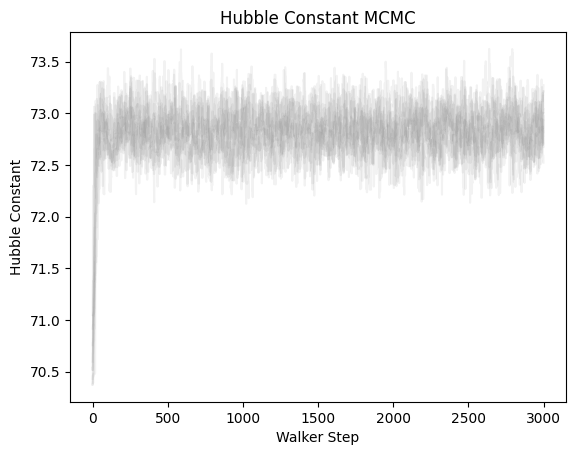

In [17]:
plt.plot(samples[:, :, 0], color='gray', alpha=0.1)
plt.xlabel('Walker Step')
plt.ylabel('Hubble Constant')
plt.title('Hubble Constant MCMC')

Now we examine the walkers hubble constant with the burn in removed. We can see the hubble constant is somewhere between 72.4 and 73.4 km/s/Mpc. This aligns pretty well with what we learned in class. 

Text(0.5, 1.0, 'Hubble Constant MCMC (Burn-in removed)')

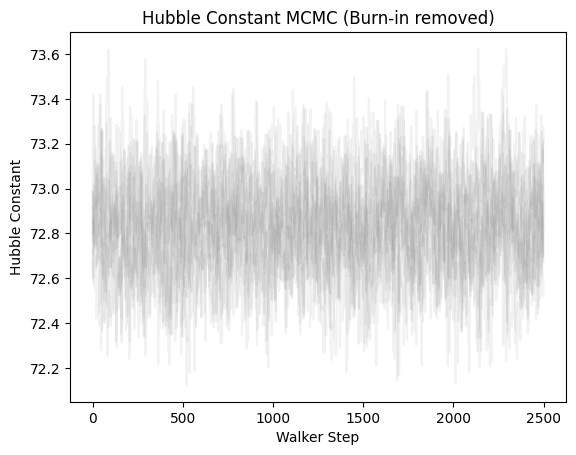

In [18]:
samples = samples[500:, :, :]
plt.plot(samples[:, :, 0], color='gray', alpha=0.1)
plt.xlabel('Walker Step')
plt.ylabel('Hubble Constant')
plt.title('Hubble Constant MCMC (Burn-in removed)')

Next we are going to examine how well our found hubble constant range works within our model. First thing we do is flatten the samples, turning each step across all the walkers into a single value. Then we take 100 random samples of these flattened steps and use them as our hubble constant to calculate the velocities across all the distance data. Then we take the median velocity across all 100 random hubble constants for each data point. 

We then plot this median velocity for each point against that points distance. When then graph one standard devation above and below the median velocity for each point. Notice that almost every point lies on our model and the standard devation across hubble constants is relatively small. This shows us that the hubble constant is likely consistant within 100 megaparsecs of us. 

Text(0.5, 1.0, 'Hubble Constant')

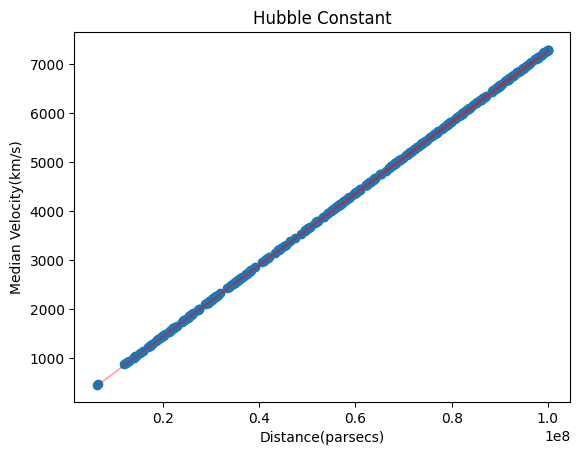

In [19]:
samples = samples.flatten()


# Calculate velocities for each resampled pair of distance and redshift
hubbles = []
for i in range(100):
    idx = np.random.randint(len(samples))
    hubble = samples[idx]
    
    hubbles.append(velocity(Close_data['Shoes_Distance_pc'], hubble))

# Plot
hubbles= np.array(hubbles)
median = np.median(hubbles, axis=0)
std = np.std(hubbles, axis=0)
plt.scatter(Close_data['Shoes_Distance_pc'], median)
plt.xlabel('Distance(parsecs)')
plt.ylabel('Median Velocity(km/s)')
plt.fill_between(Close_data['Shoes_Distance_pc'], median - std, median +std, color='r', alpha=0.3)
plt.title('Hubble Constant')

Next we are going to examine the hubble constant across the entire data set. We are going to use the same model as before, but we are going to use the entire data set. Notice how the hubble constant drops as the distance increases. This strongly implies that the hubble constant was lower in the past(because when we look at things far away, we are looking into the past due to the time it takes for light to travel). 

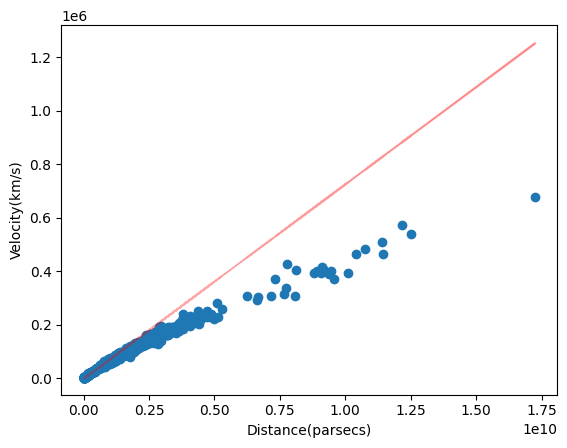

In [20]:
# Calculate velocities for each resampled pair of distance and redshift
hubbles = []
for i in range(100):
    idx = np.random.randint(len(samples))
    hubble = samples[idx]
    
    hubbles.append(velocity(data['Shoes_Distance_pc'], hubble))

# Plot
hubbles= np.array(hubbles)
median = np.median(hubbles, axis=0)
std = np.std(hubbles, axis=0)
plt.scatter(data['Shoes_Distance_pc'], data['zHD_redshift'] * 3e5)
plt.xlabel('Distance(parsecs)')
plt.ylabel('Velocity(km/s)')
plt.fill_between(data['Shoes_Distance_pc'], median - std, median + std, color='r', alpha=0.3)

Now we are going to factor in the fact that over the course of the universe Hubbles constant has changed. This means that object farther away will have a different hubble constant than objects closer to us. This because of how long it take light to travel to us from these objects, we are actually seeing them in the past. Because of this we have to intergrate through all the past hubble constants that the light has expirenced. This is done by using the following equations:
    
$d=(1+z)c\int_{0}^{z}\frac{dz}{H(z')} dz'$
     
$H(z) = H_0 \sqrt{\Omega_m(1+z)^3 + \Omega_{\Lambda}}+\Omega_{k}(1+z)^2$
       
In these equations d is the distance, z is the redshift, c is the speed of light, $H_0$ is the hubble constant, $\Omega_m$ is the matter density, $\Omega_{\Lambda}$ is the dark energy density, and $\Omega_{k}$ is the curvature density.
    
We define these functions in the code below

In [21]:
def H_z(z, H0, Omega_M, Omega_k, Omega_Lambda):
    return H0 * np.sqrt(Omega_M * (1 + z)**3 + Omega_k * (1 + z)**2 + Omega_Lambda)

def distance_speed_relation(z, H0, Omega_M, Omega_k, Omega_Lambda):
    c = 3e5
    lst = []

    integrand = lambda z: 1 / H_z(z, H0, Omega_M, Omega_k, Omega_Lambda)
    for z1 in z:
        integral, _ = quad(integrand, 0, z1)
        lst.append((1 + z1) * c * integral)
    return lst

Now we need to tweak our prior function to account for the new Hubble costant and omegas.B Because the omegas are all proportions we need to make sure they all add up to a value around 1. So we add another condition that $.95<\Omega_m + \Omega_{\Lambda} + \Omega_{k}<1.05$. Additionally we need to make sure that none of the omegas did into negative values so we add the condition that $\Omega_m > 0$ and $\Omega_{\Lambda} > 0$ and $\Omega_{k} > 0$. 

In [22]:
def ln_prior(params):
    H0, Omega_M, Omega_k, Omega_Lambda = params
    if H0 > 0 and Omega_M > 0 and Omega_k > 0 and Omega_Lambda > 0 and (Omega_M + Omega_k + Omega_Lambda) > 0.95 and (Omega_M + Omega_k + Omega_Lambda) < 1.05:
        return 0
    return -np.inf

We then also need to change our likelyhood function to account for the new distance calculation. Its similar to the old likelyhood function but now we are calculating the distance using the new equations and taking in the new parameters. 

In [23]:
def ln_likelihood(params, distance_data, zHD, zHDERR):
    H0, Omega_M, Omega_k, Omega_Lambda = params
    
    distance_predicted = distance_speed_relation(zHD, H0, Omega_M, Omega_k, Omega_Lambda)
    
    return -0.5 * np.sum((distance_data - distance_predicted) ** 2 / zHDERR**2)


The pdf does not change expect that it now takes in more arguments. This should return to us the total likelyhood of our values, using both the prior and the likelyhood function.

In [24]:
def ln_pdf(params, distance_data, zHD, zHDERR):
    p = ln_prior(params)
    if p == -np.inf:
        return -np.inf
    return p + ln_likelihood(params, distance_data, zHD, zHDERR)

This is where we run the actual walkers to see what values they burn into.

In [25]:
nwalkers = 10
ndim = 4
nsteps = 3000
initial_positions = np.random.multivariate_normal([73, 0.29, 0.01, 0.71], np.diag([1, 0.001, 0.001, 0.001]), nwalkers) 

# Run the MCMC sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_pdf, args=(data['Shoes_Distance_pc']/1E6, data['zHD_redshift'], data['zHD_redshift_error']))

sampler.run_mcmc(initial_positions, nsteps)

# Get the chain of samples
samples = sampler.get_chain()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Now we take a look at the walker values to see if they successfully converged. Luckily they all did meaning that our walkers likely worked

In [ ]:
plt.plot(samples[:, :, 1], color='gray', alpha=0.1)

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

We remove the burn in period from the walkers and take a look at the hubble constant and the omegas. We can see that the hubble constant is around 73 km/s/Mpc, $\Omega_m$ is around .32, $\Omega_{\Lambda}$ is around .68, and $\Omega_{k}$ is around 0.

In [ ]:
samples = samples[1000:, :, :]
# Mkae four subplots with each parameter
fig, axs = plt.subplots(4, 1, figsize=(10, 10))
for i in range(4):
    axs[i].plot(samples[:, :, i], color='gray', alpha=0.1)
    axs[i].set_ylabel(['H0', 'Omega_M', 'Omega_k', 'Omega_Lambda'][i])
axs[0].ylim(73,74)
plt.xlabel('Step')

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

Now we are going to flatten the values of the parameters to make it easier to graph later. This is the same process as before, where each step became a singular value across all the walkers for each parameter.

In [ ]:
samples_H0 = samples[:, :, 0].flatten()
samples_Omega_M = samples[:, :, 1].flatten()
samples_Omega_k = samples[:, :, 2].flatten()
samples_Omega_Lambda = samples[:, :, 3].flatten()


We now make a KDE plot comparing to examine where the walkers spend the most time in parameter space. 

Text(0, 0.5, 'Omega_Lambda')

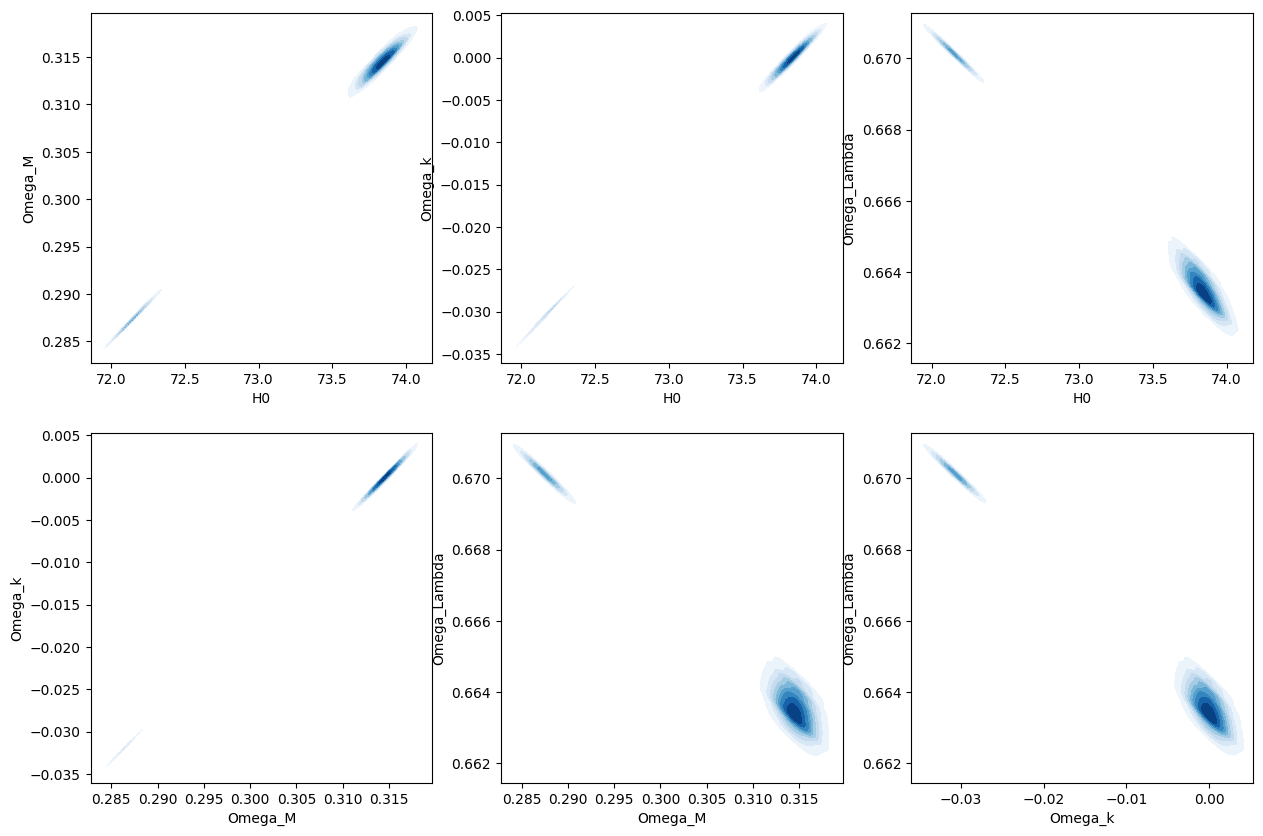

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
sns.kdeplot(x=samples_H0, y=samples_Omega_M, ax=axs[0, 0], cmap='Blues', fill=True)
axs[0, 0].set_xlabel('H0')
axs[0, 0].set_ylabel('Omega_M')
sns.kdeplot(x=samples_H0, y=samples_Omega_k, ax=axs[0, 1], cmap='Blues', fill=True)
axs[0, 1].set_xlabel('H0')
axs[0, 1].set_ylabel('Omega_k')
sns.kdeplot(x=samples_H0, y=samples_Omega_Lambda, ax=axs[0, 2], cmap='Blues', fill=True)
axs[0, 2].set_xlabel('H0')
axs[0, 2].set_ylabel('Omega_Lambda')
sns.kdeplot(x=samples_Omega_M, y=samples_Omega_k, ax=axs[1, 0], cmap='Blues', fill=True)
axs[1, 0].set_xlabel('Omega_M')
axs[1, 0].set_ylabel('Omega_k')
sns.kdeplot(x=samples_Omega_M, y=samples_Omega_Lambda, ax=axs[1, 1], cmap='Blues', fill=True)
axs[1, 1].set_xlabel('Omega_M')
axs[1, 1].set_ylabel('Omega_Lambda')
sns.kdeplot(x=samples_Omega_k, y=samples_Omega_Lambda, ax=axs[1, 2], cmap='Blues', fill=True)
axs[1, 2].set_xlabel('Omega_k')
axs[1, 2].set_ylabel('Omega_Lambda')


Now using the median values for the parameters(Hubble constant, $\Omega_m$, $\Omega_{\Lambda}$, $\Omega_{k}$) and graph a new model using this. We fill in the 1 $\sigma$ range for the model as well. We can notice by seeing how the points lie near the model that our model is working well. Additionally the 1 $\sigma$ range is extremely small, you can't see it on the graph but the stand devation is around 1.08e-11. Overall we can see that our new model and parameter values is working way better than our previous model.

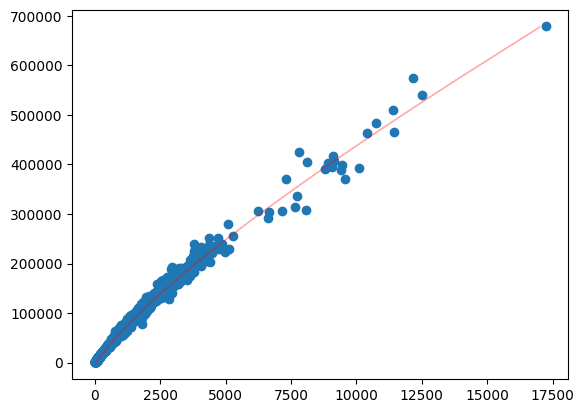

In [ ]:
median_H0 = np.median(samples_H0)
median_Omega_M = np.median(samples_Omega_M)
median_Omega_k = np.median(samples_Omega_k)
median_Omega_Lambda = np.median(samples_Omega_Lambda)

distances = []
for i in range(100):
    distances.append(distance_speed_relation(data['zHD_redshift'], median_H0, median_Omega_M, median_Omega_k, median_Omega_Lambda))

distances = np.array(distances)

median = np.median(distances, axis=0)
std = np.std(distances, axis=0)

plt.scatter(data['Shoes_Distance_pc'] * 1e-6, data['zHD_redshift'] * 3e5)
plt.fill_betweenx(data['zHD_redshift'] * 3e5, median - std, median + std, color='r', alpha=0.3)

Now we are simply going to examine the values of our parameters that worked so well. We can see that the hubble constant is around 73 km/s/Mpc, $\Omega_m$ is around .32, $\Omega_{\Lambda}$ is around .67, and $\Omega_{k}$ is incredibly close to zero. This aligns well with what we learned in class.

In [ ]:
median_H0, median_Omega_M, median_Omega_k, median_Omega_Lambda

(73.57592373636312,
 0.3167161042323662,
 1.497069410724779e-07,
 0.6683002305092862)